<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

__ Problem Statement __ :

- to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and   identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page   edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

<h1>2. Machine Learning Problem </h1>

<h2> 2.1 Data </h2>

We are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

toxic
severe_toxic
obscene
threat
insult
identity_hate

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a Multi Class classification problem, for a given Text we need to detect different types of of toxicity comments. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview/evaluation

Metric(s): 
* ROC AUC
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [81]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score
from statistics import mean
from sklearn.metrics import hamming_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score

from wordcloud import WordCloud
from collections import Counter

from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<h2> 3.1 Reading data and basic stats </h2>

In [82]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])
df.shape

Number of data points: 159571


(159571, 8)

In [83]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [84]:
df.tail(17)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159554,ffbdbb0483ed0841,and i'm going to keep posting the stuff u dele...,1,0,1,0,1,0
159555,ffc2f409658571f1,"""\n\nHow come when you download that MP3 it's ...",0,0,0,0,0,0
159556,ffc671f2acdd80e1,"I'll be on IRC, too, if you have a more specif...",0,0,0,0,0,0
159557,ffc7bbb177c3c966,It is my opinion that that happens to be off-t...,0,0,0,0,0,0
159558,ffca1e81aefc48ac,Please stop removing content from Wikipedia; i...,0,0,0,0,0,0
159559,ffca8d71d71a3fae,Image:Barack-obama-mother.jpg listed for delet...,0,0,0,0,0,0
159560,ffcdcb71854f6d8a,"""Editing of article without Consensus & Remova...",0,0,0,0,0,0
159561,ffd2e85b07b3c7e4,"""\nNo he did not, read it again (I would have ...",0,0,0,0,0,0
159562,ffd72e9766c09c97,"""\n Auto guides and the motoring press are not...",0,0,0,0,0,0
159563,ffe029a7c79dc7fe,"""\nplease identify what part of BLP applies be...",0,0,0,0,0,0


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [86]:
df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [87]:
df['tagcounts']= df['toxic'].astype(str)+ df['severe_toxic'].astype(str)+ df['obscene'].astype(str) + df['threat'].astype(str)+df['insult'].astype(str)+df['identity_hate'].astype(str)
df['tagcounts'] = df['tagcounts'].apply(lambda text: text.count("1"))

In [88]:
df.tail(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tagcounts
159551,ffbc2db4225258dd,While about half the references are from BYU-I...,0,0,0,0,0,0,0
159552,ffbcd64a71775e04,Prague Spring \n\nI think that Prague Spring d...,0,0,0,0,0,0,0
159553,ffbd331a3aa269b9,I see this as having been merged; undoing one ...,0,0,0,0,0,0,0
159554,ffbdbb0483ed0841,and i'm going to keep posting the stuff u dele...,1,0,1,0,1,0,3
159555,ffc2f409658571f1,"""\n\nHow come when you download that MP3 it's ...",0,0,0,0,0,0,0
159556,ffc671f2acdd80e1,"I'll be on IRC, too, if you have a more specif...",0,0,0,0,0,0,0
159557,ffc7bbb177c3c966,It is my opinion that that happens to be off-t...,0,0,0,0,0,0,0
159558,ffca1e81aefc48ac,Please stop removing content from Wikipedia; i...,0,0,0,0,0,0,0
159559,ffca8d71d71a3fae,Image:Barack-obama-mother.jpg listed for delet...,0,0,0,0,0,0,0
159560,ffcdcb71854f6d8a,"""Editing of article without Consensus & Remova...",0,0,0,0,0,0,0


In [89]:
df.tagcounts.value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: tagcounts, dtype: int64

In [90]:
df.shape[0] - df.tagcounts.value_counts()[0]

16225

<h3>3.2.3 Checking for Duplicates </h3>

In [91]:
df[df.duplicated(['comment_text'])]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tagcounts


In [92]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['comment_text']].groupby(['comment_text']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


In [93]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate, tagcounts]
Index: []


<h2>Comment length frequency</h3>

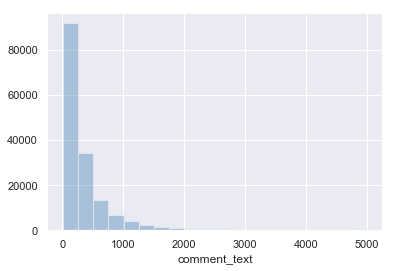

In [106]:
sns.set(color_codes=True)
comment_len = df.comment_text.str.len()
sns.distplot(comment_len, kde=False, bins=20, color="steelblue")

We obseserved that most of the comments are short, only a few comments which are longer than 1000 words.

In [101]:
df_labels = df[['toxic', 'severe_toxic',
                      'obscene', 'threat', 'insult', 'identity_hate']]
label_count = df_labels.sum()

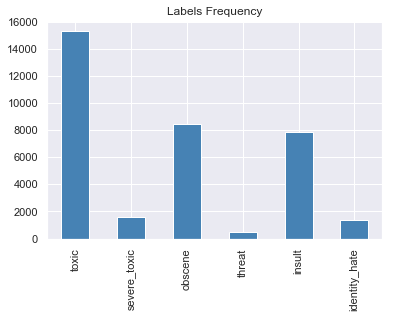

In [102]:
label_count.plot(kind='bar', title='Labels Frequency', color='steelblue')

<b>Observations:</b><br />
1. Toxic datapoints are more observations than threats.

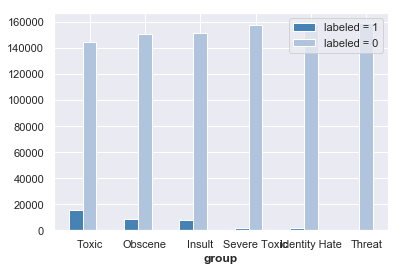

In [109]:
# bar graph for visualising distribution of classes within each label.
barWidth = 0.25

bars1 = [sum(df['toxic'] == 1), sum(df['obscene'] == 1), sum(df['insult'] == 1), sum(df['severe_toxic'] == 1),
         sum(df['identity_hate'] == 1), sum(df['threat'] == 1)]
bars2 = [sum(df['toxic'] == 0), sum(df['obscene'] == 0), sum(df['insult'] == 0), sum(df['severe_toxic'] == 0),
         sum(df['identity_hate'] == 0), sum(df['threat'] == 0)]

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='steelblue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='lightsteelblue', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate',
                                                       'Threat'])
plt.legend()
plt.show()

<h2> 3.4 Preprocessing of Text </h2>

In [139]:
import nltk
from nltk import word_tokenize
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
#stemmer = PorterStemmer("english")
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AkshayC27\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AkshayC27\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [140]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    #porter = PorterStemmer()
    stemmer = SnowballStemmer("english")
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = stemmer.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [143]:
df["comment_text"][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [144]:
a = df["comment_text"][0] 
preprocess(a)

'explanation why the edits made under my username hardcore metallica fan were reverted  they were not vandalisms  just closure on some gas after i voted at new york dolls fac  and please do not remove the template from the talk page since i am retired now 89 205 38 27'

In [145]:
df["comment_text"] = df["comment_text"].fillna("").apply(preprocess)

In [153]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tagcounts
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am ...,0,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war i...,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can not make any real suggestions on im...,0,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0,0,0,0,0,0,0


In [156]:
comment_text_length = [len(m_str.split()) for m_str in df["comment_text"].tolist()]

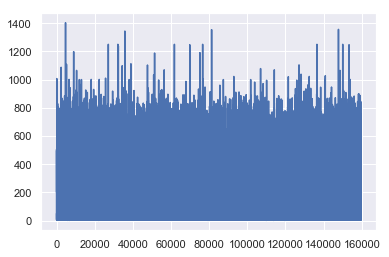

In [157]:
plt.plot(comment_text_length)

In [158]:
print( "Max Length ", max(comment_text_length))
print( "Min Length ", min(comment_text_length))

Max Length  1403
Min Length  1


In [160]:
df.to_csv("Preprocessed_data.csv", index=False)

In [174]:
from wordcloud import WordCloud,STOPWORDS

def showWordCloud(df, label):
  plt.figure(figsize=(11,11))

  text = df[df[label]==1]["comment_text"].tolist()
  label_img = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=1200,
                          height=800,
                         ).generate(" ".join(text))

  plt.title(label,fontsize=40)
  plt.imshow(label_img)

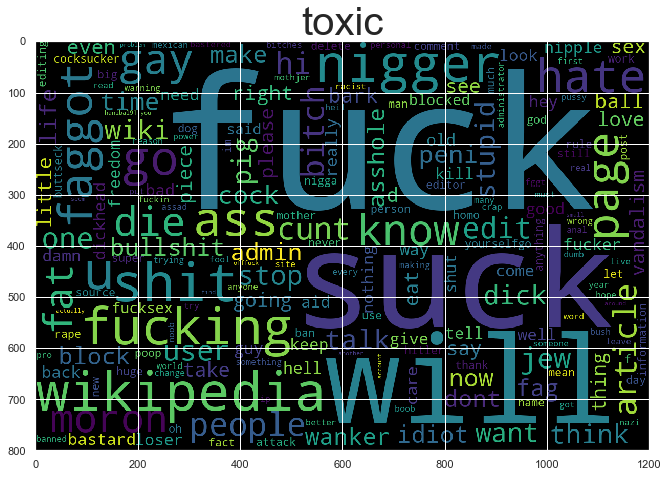

In [175]:
showWordCloud(df, "toxic")

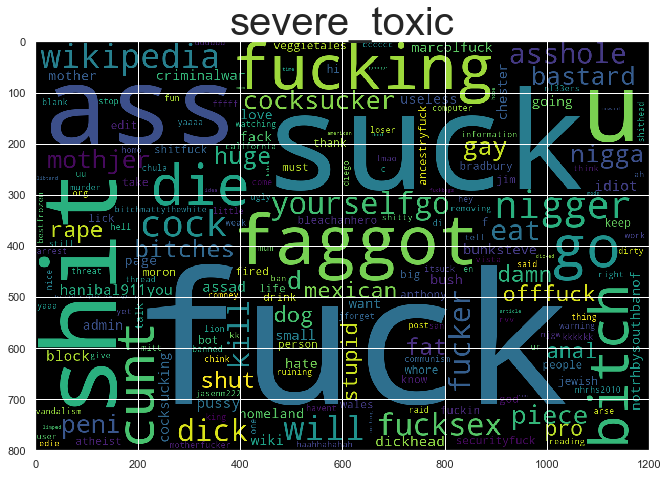

In [176]:
showWordCloud(df, "severe_toxic")

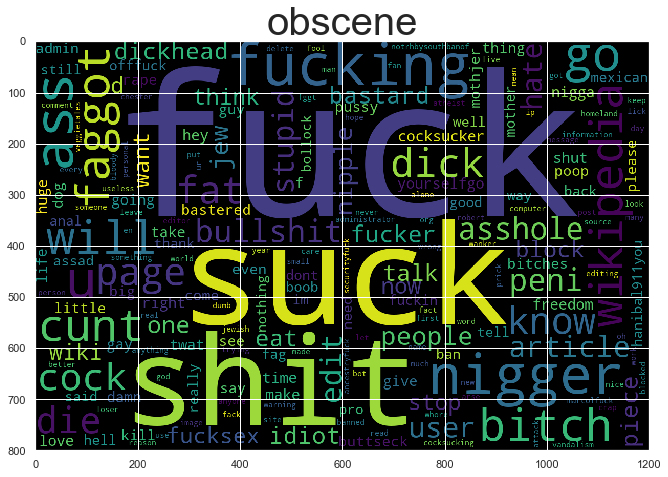

In [177]:
showWordCloud(df, "obscene")

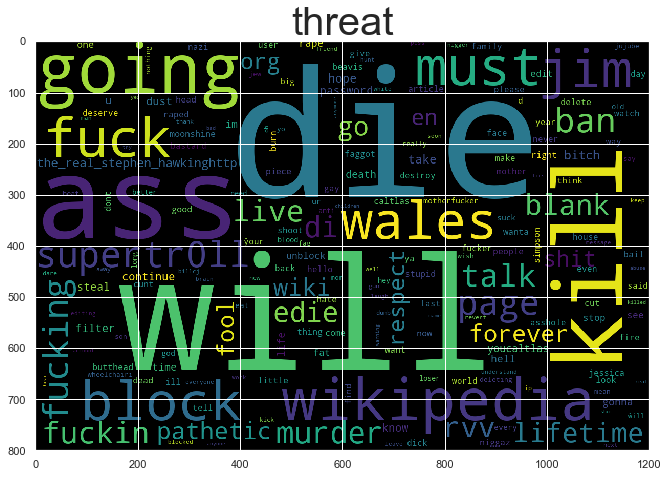

In [178]:
showWordCloud(df, "threat")

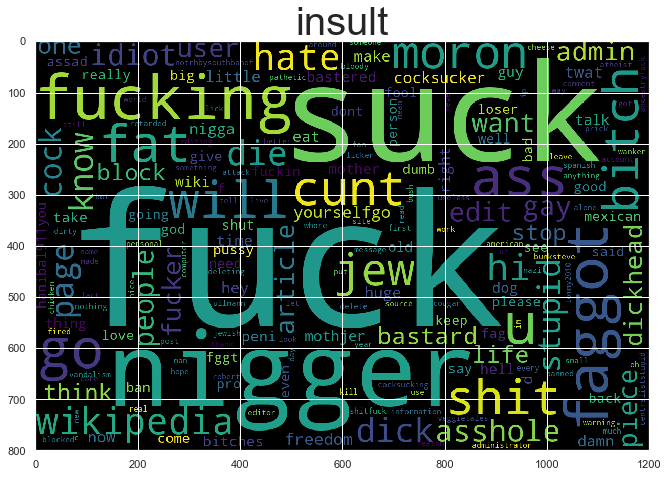

In [180]:
showWordCloud(df, "insult")

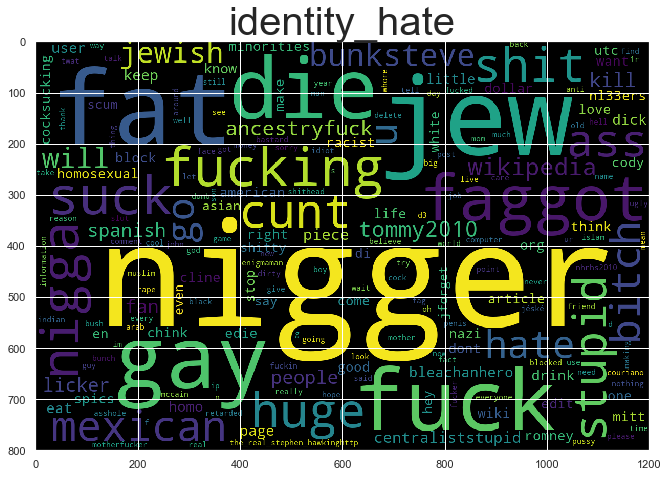

In [181]:
showWordCloud(df, "identity_hate")

In [187]:
train =df
test = pd.read_csv('test.csv')

In [193]:
train.shape,test.shape

((159571, 9), (153164, 2))

In [195]:
df_1 = pd.concat([train['comment_text'], test['comment_text']], axis=0)
df_1 = df_1.fillna("unknown")
nrow_train = train.shape[0]

vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
X = vectorizer.fit_transform(df_1)

col = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

preds = np.zeros((test.shape[0], len(col)))


loss = []

for i, j in enumerate(col):
    print('===Fit '+j)
    model = LogisticRegression()
    model.fit(X[:nrow_train], train[j])
    preds[:,i] = model.predict_proba(X[nrow_train:])[:,1]
    
    pred_train = model.predict_proba(X[:nrow_train])[:,1]
    print('ROC AUC:', roc_auc_score(train[j], pred_train))
    loss.append(roc_auc_score(train[j], pred_train))
    

    print('mean column-wise ROC AUC:', np.mean(loss))

===Fit toxic
ROC AUC: 0.9838432410438728
===Fit severe_toxic
ROC AUC: 0.9922788616913041
===Fit obscene
ROC AUC: 0.9929848769551489
===Fit threat
ROC AUC: 0.9950878182959063
===Fit insult
ROC AUC: 0.9872557087796631
===Fit identity_hate
ROC AUC: 0.9900384649255616
mean column-wise ROC AUC: 0.9902481619485761


# Featurization

In [213]:
test_labels = ["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

test_y = pd.read_csv("test_labels.csv")

In [212]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

In [206]:
vector = TfidfVectorizer(ngram_range=(1, 1), analyzer='word',
                         tokenizer=tokenize, stop_words='english',
                         strip_accents='unicode', use_idf=1, min_df=10,max_features=50000)
X_train = vector.fit_transform(train['comment_text'])
X_test = vector.transform(test['comment_text'])

<h1>Modeling and Evaluation</h1>

<h2>Cross Validation</h2>

In [207]:
# Creating classifiers with default parameters initially.
clf1 = MultinomialNB()
clf2 = LogisticRegression()
clf3 = LinearSVC()

In [208]:
def cross_validation_score(classifier, X_train, y_train):
    '''
    Iterate though each label and return the cross validation F1 and Recall score 
    '''
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]

    for label in test_labels:
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=3, scoring='recall')
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='roc_auc')
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods

In [209]:
# Calculating the cross validation ROC_AUC and Recall score for our 3 baseline models.
methods1_cv = pd.DataFrame(cross_validation_score(clf1, X_train, train))
methods2_cv = pd.DataFrame(cross_validation_score(clf2, X_train, train))
methods3_cv = pd.DataFrame(cross_validation_score(clf3, X_train, train))

In [210]:
# Creating a dataframe to show summary of results.
methods_cv = pd.concat([methods1_cv, methods2_cv, methods3_cv])
methods_cv.columns = ['Model', 'Label', 'Recall', 'ROC_AUC']
meth_cv = methods_cv.reset_index()
meth_cv[['Model', 'Label', 'Recall', 'ROC_AUC']]

,Model,Label,Recall,ROC_AUC
0,MultinomialNB,toxic,0.452661,0.949593
1,MultinomialNB,severe_toxic,0.011285,0.948176
2,MultinomialNB,obscene,0.427031,0.952932
3,MultinomialNB,threat,0.000000,0.872224
4,MultinomialNB,insult,0.325123,0.949840
5,MultinomialNB,identity_hate,0.004270,0.911439
6,LogisticRegression,toxic,0.586374,0.968724
7,LogisticRegression,severe_toxic,0.243248,0.983939
8,LogisticRegression,obscene,0.615693,0.981392
9,LogisticRegression,threat,0.113063,0.980551


Based on the cross validation above, we noticed that overall, the Logistic Regression model and linear SVC model perform better. As a baseline model, Multinomial Naive Bayes does not perform well, especially for the threat label and identity_hate label because these two labels have the least number of observations.

# Modeling and Evaluation

In [226]:
def score(classifier, X_train, y_train, X_test, y_test):
    """
    Calculate Hamming-loss, F1, Recall for each label on test dataset.
    """
    methods = []
    hloss = []
    name = classifier.__class__.__name__.split('.')[-1]
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']

    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted_train = classifier.predict(X_train)
        predicted = classifier.predict(X_test)

        predict_df[label] = predicted

        recall = recall_score(y_test[y_test[label] != -1][label],
                              predicted[y_test[label] != -1],
                              average="weighted")
        f1 = f1_score(y_test[y_test[label] != -1][label],
                      predicted[y_test[label] != -1],
                      average="weighted")
        
        
        f1_train = f1_score(y_train[y_train[label] != -1][label],
                      predicted_train[y_train[label] != -1],
                      average="weighted")        
        
        

        conf_mat = confusion_matrix(y_test[y_test[label] != -1][label],
                                    predicted[y_test[label] != -1])

        methods.append([name, label, recall, f1_train ,f1, conf_mat])

    hamming_loss_score = hamming_loss(test_y[test_y['toxic'] != -1].iloc[:, 1:7],
                                      predict_df[test_y['toxic'] != -1].iloc[:, 1:7])
    hloss.append([name, hamming_loss_score])

    return hloss, methods

In [227]:
h1, methods1 = score(clf1, X_train, train, X_test, test_y)
h2, methods2 = score(clf2, X_train, train, X_test, test_y)
h3, methods3 = score(clf3, X_train, train, X_test, test_y)

In [228]:
# Creating a dataframe to show summary of results.
methods1 = pd.DataFrame(methods1)
methods2 = pd.DataFrame(methods2)
methods3 = pd.DataFrame(methods3)
methods = pd.concat([methods1, methods2, methods3])
methods.columns = ['Model', 'Label', 'Recall', 'F1_train', 'F1', 'Confusion_Matrix']
meth = methods.reset_index()
meth[['Model', 'Label', 'Recall', 'F1_train','F1']]

,Model,Label,Recall,F1_train,F1
0,MultinomialNB,toxic,0.934978,0.944412,0.930795
1,MultinomialNB,severe_toxic,0.994420,0.985868,0.992110
2,MultinomialNB,obscene,0.962847,0.968345,0.957762
3,MultinomialNB,threat,0.996702,0.995506,0.995056
4,MultinomialNB,insult,0.960393,0.962207,0.953660
5,MultinomialNB,identity_hate,0.988887,0.987098,0.983408
6,LogisticRegression,toxic,0.936212,0.958086,0.937398
7,LogisticRegression,severe_toxic,0.993091,0.989472,0.992752
8,LogisticRegression,obscene,0.966066,0.977537,0.964315
9,LogisticRegression,threat,0.996593,0.996460,0.995784
